## Loading Packages and docking drive

In [ ]:
#%%capture
!apt-get update
# Install GDAL and Geopandas
!apt-get install libgdal-dev 
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# One may also need to add a shortcut to the shared drive like in 
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab/54352105#54352105

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab import files

## Pull in and stage cell_id data to match the MODIS logic 
From SnowCast Showdown Data Wrangling.ipynb

In [ ]:
gridcells = gpd.read_file('/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/grid_cells.geojson')
print(gridcells.head())

                                cell_id  ...                                           geometry
0  0003f387-71c4-48f6-b2b0-d853bd4f0aba  ...  POLYGON ((-118.71895 37.07419, -118.71895 37.0...
1  000617d8-8c14-43e2-b708-7e3a69fe3cc3  ...  POLYGON ((-107.07679 37.78042, -107.07679 37.7...
2  000863e7-21e6-477d-b799-f5675c348627  ...  POLYGON ((-119.40167 37.02400, -119.40167 37.0...
3  000ba8d9-d6d5-48da-84a2-1fa54951fae1  ...  POLYGON ((-119.32082 37.43171, -119.32082 37.4...
4  00146204-d4e9-4cd8-8f86-d1ef133c5b6d  ...  POLYGON ((-118.52132 36.65735, -118.52132 36.6...

[5 rows x 3 columns]


In [ ]:
import json 

# with open('/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/grid_cells.geojson') as f:
#    data = json.load(f)
# redundant to cell above

In [ ]:
traindf = pd.read_csv("/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/train_labels.csv")

traindf = traindf.melt(id_vars=["cell_id"]).dropna().reset_index(drop = True)
traindf.rename(columns = {"cell_id":"cell_id", "variable":"date", "value":"SWE"}, inplace = True)

traindf = traindf.merge(gridcells, how = 'left', on='cell_id')


traindf = gpd.GeoDataFrame(traindf, crs ="EPSG:4326")
traindf.head()

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."


In [ ]:
from datetime import datetime, timedelta
traindf = traindf.loc[pd.to_datetime(traindf.date) >= datetime.strptime("2016-01-01", "%Y-%m-%d")].reset_index(drop = True)

In [ ]:
traindf.head()

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2016-01-05,10.6,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2016-01-05,2.0,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2016-01-05,9.2,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."


In [ ]:
import shutil
import os
import requests
import ee
from datetime import datetime, timedelta

traindf["date"] = pd.to_datetime(traindf.date)


#I am creating a string version of the date to use as a filename
traindf["datestring"] = traindf.date.map(lambda d: str(d.year)+d.strftime('%j'))

#Now I calculate my centroid from the provided geometry
#Ignore the warnings this creates. It is in a projected crs
traindf["centroid"] = traindf.geometry.to_crs('EPSG:32631').centroid
traindf["center_lat"] = traindf.centroid.y
traindf["center_long"] = traindf.centroid.x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [ ]:
traindf.head()

,cell_id,date,SWE,region,geometry,datestring,centroid,center_lat,center_long
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2016-01-05,10.6,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1...",2016005,POINT (-4099016.572 13697382.590),41.166647,-121.939413
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6...",2016005,POINT (-4350252.837 13751971.654),39.675880,-120.618890
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2...",2016005,POINT (-4574780.281 13818928.867),38.279274,-119.612777
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2016-01-05,2.0,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5...",2016005,POINT (-4657750.653 12147417.344),44.581994,-107.198060
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2016-01-05,9.2,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4...",2016005,POINT (-5257960.063 12391616.347),40.398034,-106.605172


## Sentinel 1 main function



In [ ]:

def pull_Sentinel(traindf, overwrite = False, names_only = False ):
  ##Main loop that iterates over areas and stores images in file
  ##For test image of one AOI see below
  filelocations = []
  x= 0


  for i in range(len(traindf.SWE)):
    #create a name for the image
    pict_name = traindf.cell_id[i] + '_sentinel1_VV_' + traindf.datestring[i] + '.jpg'

    #create the whole filename with path to the correct folder
    filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen1_Data', pict_name)

    if names_only:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    elif os.path.exists(filename) and not overwrite:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    else:

      #define area of interest by coordinates
      aoi = ee.Geometry.Point((traindf.center_long[i], traindf.center_lat[i])).buffer(100)
      #print(aoi)
      start_date = traindf.date[i] - timedelta(days = 28)
      end_date = traindf.date[i] + timedelta(days = 1)

      year = start_date.year
      #print(year)

      if year >=2016:
        x+=1
        try:
          #print("calculating")
          # Sentinel-1 image filtered on date range and on aoi
          se2 = ee.ImageCollection('COPERNICUS/S1_GRD')\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())\
          .filterDate(start_date, end_date)\
          .filterBounds(aoi)\
          .first()

          #Create a ratio band of VV/VH

          VVVH = (se2.select('VV').divide(se2.select('VH')))

          se2 = se2.addBands(VVVH.rename('VVVH'))

          rgb = ['VV', 'VH', 'VVVH']


          url = se2.select(rgb).clip(aoi).getThumbURL({'min': -50, 'max': 0, 'region': aoi, 'format': 'jpg'})

          #add the name to my list I created earlier
          filelocations.append(filename)

          #now I open the url and download the image to the specified file location
          response = requests.get(url, stream=True)
          with open(filename, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
          del response
        
        except Exception as e:
          filelocations.append("NULL")
        
      else:
        x+=1
        #print("skip")
        filelocations.append("NULL")

      if x % 5000 == 0:
        print(x, "files complete")

  traindf['sentinel1a_filelocation'] = filelocations

###Sentinel 1a

When both sentinel satellites are working you get a 6 day repeat. With one down it is a 12 day... so here we have 14 day range but we'd want it to be down to 7 when normal operating is occuring.

In [ ]:
##Test statement for ee API
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

pull_Sentinel(traindf, overwrite = False, names_only = True )



5000 files already exist
10000 files already exist
15000 files already exist
20000 files already exist
25000 files already exist
30000 files already exist
35000 files already exist
40000 files already exist
45000 files already exist
50000 files already exist
55000 files already exist
60000 files already exist
65000 files already exist


In [ ]:
#Check to confirm file locations were written to dataframe
traindf.head()

,cell_id,date,SWE,region,geometry,datestring,centroid,center_lat,center_long,sentinel1a_filelocation
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2016-01-05,10.6,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1...",2016005,POINT (-4099016.572 13697382.590),41.166647,-121.939413,/content/drive/MyDrive/snowcapstone team sprin...
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6...",2016005,POINT (-4350252.837 13751971.654),39.675880,-120.618890,/content/drive/MyDrive/snowcapstone team sprin...
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2...",2016005,POINT (-4574780.281 13818928.867),38.279274,-119.612777,/content/drive/MyDrive/snowcapstone team sprin...
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2016-01-05,2.0,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5...",2016005,POINT (-4657750.653 12147417.344),44.581994,-107.198060,/content/drive/MyDrive/snowcapstone team sprin...
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2016-01-05,9.2,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4...",2016005,POINT (-5257960.063 12391616.347),40.398034,-106.605172,/content/drive/MyDrive/snowcapstone team sprin...


In [ ]:
#Write to csv 
traindf.to_csv('/content/drive/MyDrive/snowcapstone team spring 2022/SENTINEL1_FileLocations.csv', index=False)

## Sentinel 2 ingestion

### Google Earth Engine version (not permissible for competition)

In [ ]:

def pull_Sentinel(traindf, overwrite = False, names_only = False ):
  ##Main loop that iterates over areas and stores images in file
  ##For test image of one AOI see below
  filelocations = []
  x= 0
  proj = ee.Projection('EPSG:32631')

  for i in range(len(traindf.SWE)):
    #create a name for the image
    pict_name = traindf.cell_id[i] + '_sentinel2_' + traindf.datestring[i] + '.jpg'

    #create the whole filename with path to the correct folder
    filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_Data',pict_name)

    if names_only:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    elif os.path.exists(filename) and not overwrite:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    else:

       #define area of interest by coordinates
      aoi = ee.Geometry.Point((traindf.center_long[i], traindf.center_lat[i]), proj = proj)
      #print(aoi)
      start_date = traindf.date[i] - timedelta(days = 90)
      end_date = traindf.date[i] + timedelta(days = 1)

      year = traindf.date[i].year
      #print(year)

          #umbImages = ee.ImageCollection('COPERNICUS/S2').filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filterBounds(aoi).size();
          #print('numbImages', numbImages)
      if year >=2016:
        x+=1
        #print("calculating")
        rgb = ['B2','B11','B12']
        # Sentinel-2 image filtered on date range and on aoi
        se2 = ee.ImageCollection('COPERNICUS/S2') \
                        .filter(ee.Filter.date(start_date, end_date)) \
                        .filter(ee.Filter.notNull(['system:index'])) \
                        .select(rgb) \
                        .sort('system:index', False) 


        #Because the image collection is limited to a single day, there is only one image
        #So I just take it
        point = se2.first().reproject(crs = 'EPSG:32631').clip(aoi.buffer(100))

        # Get individual band arrays and build them into an RGB image
        # The "buffer" is a circular distance around the point, measured in meters right now it is 100km
        #rgb = ee.Image.rgb(point.clip(aoi.buffer(1)).select(rgb[0]), #I divide by 100 to get it between 0 and 1
        #                  point.clip(aoi.buffer(1)).select(rgb[1]), #I divide by 100 to get it between 0 and 1
        #                  point.clip(aoi.buffer(1)).select(rgb[2])).visualize() #I divide by 10000 to get it between 0 and 1

        #Now I get the url for the image
        url = point.getThumbURL({'bands': rgb, 'min': 0, 'max': 2500, 'gamma': 1.1})

        #add the name to my list I created earlier
        filelocations.append(filename)

        #now I open the url and download the image to the specified file location
        response = requests.get(url, stream=True)
        with open(filename, 'wb') as out_file:
          shutil.copyfileobj(response.raw, out_file)
        del response
        
      else:
        x+=1
        #print("skip")
        filelocations.append("No Data")

      if x % 5000 == 0:
        print(x, "files complete")

  traindf['sentinel2_filelocation'] = filelocations

In [ ]:
import IPython.display as disp
filelocations = []
x= 0
proj = ee.Projection('EPSG:32631')
for i in range(400,401):
  #define area of interest by coordinates
  aoi = ee.Geometry.Point((traindf.center_long[i], traindf.center_lat[i]), proj = proj)
  #print(aoi)
  start_date = traindf.date[i] - timedelta(days = 90)
  end_date = traindf.date[i] + timedelta(days = 1)

  year = traindf.date[i].year
  #print(year)

      #umbImages = ee.ImageCollection('COPERNICUS/S2').filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filterBounds(aoi).size();
      #print('numbImages', numbImages)
  if year >=2016:
    x+=1
    #print("calculating")
    rgb = ['B2','B11','B12']
    # Sentinel-2 image filtered on date range and on aoi
    se2 = ee.ImageCollection('COPERNICUS/S2') \
                    .filter(ee.Filter.date(start_date, end_date)) \
                    .filter(ee.Filter.notNull(['system:index'])) \
                    .select(rgb) \
                    .sort('system:index', False) 


    #Because the image collection is limited to a single day, there is only one image
    #So I just take it
    point = se2.first().reproject(crs = 'EPSG:32631').clip(aoi.buffer(100))

    # Get individual band arrays and build them into an RGB image
    # The "buffer" is a circular distance around the point, measured in meters right now it is 100km
    #rgb = ee.Image.rgb(point.clip(aoi.buffer(1)).select(rgb[0]), #I divide by 100 to get it between 0 and 1
    #                  point.clip(aoi.buffer(1)).select(rgb[1]), #I divide by 100 to get it between 0 and 1
    #                  point.clip(aoi.buffer(1)).select(rgb[2])).visualize() #I divide by 10000 to get it between 0 and 1

    #Now I get the url for the image
    url = point.getThumbURL({'bands': rgb, 'min': 0, 'max': 2500, 'gamma': 1.1})

In [ ]:
url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56f86ae083344c000efe1f077c2710d2-d7b91fcdc9364c246382bedfbfe0c2f5:getPixels'

In [ ]:
##Test statement for ee API
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

## Ingest data
pull_Sentinel(traindf, overwrite = True, names_only= False)

KeyboardInterrupt: ignored

Possible better image save solution: https://geemap.org/notebooks/21_export_map_to_html_png/

(2, 2, 4)
The image consists of 4 pixels


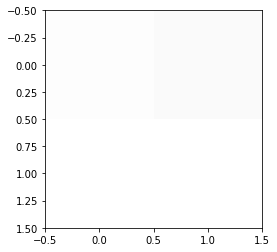

In [ ]:
test1=plt.imread('/content/drive/MyDrive/snowcapstone team spring 2022/Sen1_Data/2f5c1968-2c34-4539-a9f4-38298d0de925_sentinel1_VV_2016033.jpg')
print(test1.shape)
print(f"The image consists of {test1.shape[0] * test1.shape[1]} pixels")
plt.imshow(test1);

In [ ]:
test1

array([[[0, 0, 0, 2],
        [0, 0, 0, 5]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
test2

array([[[3, 3, 3, 8]]], dtype=uint8)

(1, 1, 4)
The image consists of 1 pixels


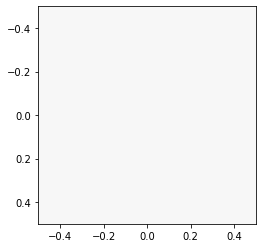

In [ ]:
test2=plt.imread('/content/drive/MyDrive/snowcapstone team spring 2022/Sen1_Data/2f266b81-aad3-4c26-ac69-1bd04a208bf7_sentinel1_VV_2016033.jpg')
print(test2.shape)
print(f"The image consists of {test2.shape[0] * test2.shape[1]} pixels")
plt.imshow(test2);


##Single trial example
### Sentinel 2 with cloud masking
https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless



In [ ]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# get a single polygon
aoi = ee.Geometry.Polygon(traindf.geometry[0])
print(aoi)
#print(aoi)

# Sentinel-2 image filtered on 2019 and on aoi
se2 = ee.ImageCollection('COPERNICUS/S2').filterDate("2019-01-01","2019-12-31").filterBounds(aoi).median().divide(10000)

rgb = ['B12','B11','B2']

# set some thresholds
rgbViz = {"min":0.0, "max":0.9,"bands":rgb}


# initialize our map
map1 = geemap.Map()
map1.centerObject(aoi, 7)
map1.addLayer(se2.clip(aoi), rgbViz, "S2")

map1.addLayerControl()
map1

TypeError: ignored

In [ ]:
##Cloud mask filster

def se2mask(image):
    quality_band = image.select('QA60')
    
    # using the bit mask for clouds and cirrus clouds respectively
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    
    # we only want clear skies
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    
    # we'll divide by 10000 to make interpreting the reflectance values easier
    return image.updateMask(mask).divide(10000)
    
se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2019-01-01","2019-12-31").filterBounds(aoi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median()

# initialize our map
map2 = geemap.Map()
map2.centerObject(aoi, 7)
map2.addLayer(se2.clip(aoi), rgbViz, "S2")

map2.addLayerControl()
map2

Map(center=[37.07777579811751, -118.72344474923563], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
#se2.getInfo()

#url = se2.select(rgb).clip(aoi).getThumbURL({'min': -20, 'max': 0})

url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/01c290075fbda695e0a58f1b8e9f3bc0-3bff08612d82e5765ab4f731dd2720d7:getPixels'

## Reading into Numpy Arrays

https://gis.stackexchange.com/questions/342671/get-numpy-arrays-from-google-earth-engine

Info on reducers: 
https://colab.research.google.com/github/csaybar/EEwPython/blob/master/5_Reducer.ipynb

In [ ]:
## Take Image Collection and apply a reducer... here I've applied the median over one month and min max:

aoi_test = ee.Geometry.Polygon(data['features'][0]['geometry']['coordinates'])

# Load and filter the Sentinel-2 image collection.
collection = ee.ImageCollection('COPERNICUS/S2')\
               .filterDate('2020-01-01', '2020-01-31')\
               .filterBounds(aoi_test)

# Reduce the collection.
reduced_min_max = collection.reduce(ee.Reducer.minMax())
reduced_median = collection.reduce(ee.Reducer.median())

In [ ]:
reduced_min_max.getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B1_min'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B1_max'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B2_min'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B2_max'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B3_min'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 65535,
    'mi

In [ ]:
# Define an image.
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810') \
  .select(['B4', 'B5', 'B6'])

# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B4')
band_arr_b5 = band_arrs.get('B5')
band_arr_b6 = band_arrs.get('B6')

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)
print(rgb_img.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3500)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

In [ ]:
mytask = ee.batch.Export.table.toDrive(collection=reduced_min_max, folder='data_earth_engine', description='lossyear', fileFormat='CSV', selectors=props)

ee.batch.data.startProcessing(mytask.id, mytask.config)

NameError: ignored

# Test Area

In [ ]:
pip install geemap

     |████████████████████████████████| 1.9 MB 9.8 MB/s 
     |████████████████████████████████| 1.3 MB 41.8 MB/s 
     |████████████████████████████████| 8.5 MB 36.1 MB/s 
     |████████████████████████████████| 176 kB 56.7 MB/s 
     |████████████████████████████████| 98 kB 8.1 MB/s 
     |████████████████████████████████| 1.7 MB 50.6 MB/s 
     |████████████████████████████████| 3.3 MB 73.4 MB/s 
     |████████████████████████████████| 99 kB 10.9 MB/s 
     |████████████████████████████████| 76 kB 6.3 MB/s 
     |████████████████████████████████| 216 kB 70.4 MB/s 
     |████████████████████████████████| 5.4 MB 24.6 MB/s 
     |████████████████████████████████| 130 kB 61.9 MB/s 
     |████████████████████████████████| 95 kB 3.8 MB/s 
     |████████████████████████████████| 1.2 MB 29.7 MB/s 
     |████████████████████████████████| 44 kB 2.9 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 428 kB 52.5 MB/s 
     |████████████████████

In [ ]:
pip install geeutils

In [ ]:
import ee
import geemap

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()
        
import sys
sys.path.append('../src/geepatches')
import geeutils

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=o8Q43wvukcyuhZaYHhk_hQlfimXu0_s0sL1GlR47GmI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhHEXHHbCGkjfOEbAfxCO-jVq7FXP9hne5j3Zi9YaA881aHy5Uq7Ak

Successfully saved authorization token.


Testing with one 1k x 1k location in our region:

In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(1000000)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 1000000:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

At buffer of 1000000:
all        :            7272
none       :               0
VV only    :               0    0.0%
VH only    :               0    0.0%
HV only    :               0    0.0%
HH only    :               0    0.0%
VV+VH  only:            7272   100.0%
HV+HH  only:               0    0.0%
VV+VH+HV+HH:               0    0.0%


In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(100)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 100:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

At buffer of 100:
all        :             145
none       :               0
VV only    :               0    0.0%
VH only    :               0    0.0%
HV only    :               0    0.0%
HH only    :               0    0.0%
VV+VH  only:             145   100.0%
HV+HH  only:               0    0.0%
VV+VH+HV+HH:               0    0.0%


In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(1000)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 1000:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

At buffer of 1000:
all        :             145
none       :               0
VV only    :               0    0.0%
VH only    :               0    0.0%
HV only    :               0    0.0%
HH only    :               0    0.0%
VV+VH  only:             145   100.0%
HV+HH  only:               0    0.0%
VV+VH+HV+HH:               0    0.0%


In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(10000)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 10000:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

At buffer of 10000:
all        :             201
none       :               0
VV only    :               0    0.0%
VH only    :               0    0.0%
HV only    :               0    0.0%
HH only    :               0    0.0%
VV+VH  only:             201   100.0%
HV+HH  only:               0    0.0%
VV+VH+HV+HH:               0    0.0%


In [ ]:
eeregion          = ee.Geometry.Point((-121.939413466388, 41.1666473902759)).buffer(1000)
#eeregion          = geeutils.squareareaboundsroi(eepoint, 1000) # 2km x 2km
eedatefrom        = ee.Date('2016-01-01')
eedatetill        = ee.Date('2021-01-01')            # Beware for the "User memory limit exceeded."

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filterBounds(eeregion)
                     .filter(ee.Filter.date(eedatefrom, eedatetill)))

#
# collection info
#
#print(f"S1_GRD szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
size_all_nf     = (eeimagecollection.size().getInfo())
print(f"all (nf)        : {size_all:15d}")



eeimagecollectionf = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                     .filterBounds(eeregion)
                     .filter(ee.Filter.date(eedatefrom, eedatetill)))
#
# collection info
#
#print(f"S1_GRD_FLOAT szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
#print(f"S1_GRD_FLOAT szestimatevaluesinfo: \n{geeutils.szestimatevaluesinfo(eeimagecollection)}\n")

size_all_f     = (eeimagecollectionf.size().getInfo())
print(f"all (f)        : {size_all:15d}")



###################################################
# convert natural to decibel
###################################################
def tosigmadb(image):
    return (image
            .addBands(ee.Image(image.select('VV').log10().multiply(10.0)), overwrite=True)
            .addBands(ee.Image(image.select('VH').log10().multiply(10.0)), overwrite=True))

eeimagecollection = eeimagecollection.map(tosigmadb)

#
# collection info
#
#print(f"tosigmadb S1_GRD_FLOAT szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
size_convert    = (eeimagecollectionf.size().getInfo())

print(f"tosigmadb S1_GRD_FLOAT szestimatevaluesinfo: \n{geeutils.szestimatevaluesinfo(eeimagecollection)}\n")



eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filterBounds(eeregion)
                     .filter(ee.Filter.date(eedatefrom, eedatetill)))

###################################################
# convert decibel to natural
###################################################
def fromsigmadb(image):
    return (image
            .addBands(ee.Image(ee.Image(10.0).pow(image.select('VV').divide(10.0))).select([0], ['VV']), overwrite=True)
            .addBands(ee.Image(ee.Image(10.0).pow(image.select('VH').divide(10.0))).select([0], ['VH']), overwrite=True))

eeimagecollection = eeimagecollection.map(fromsigmadb)

#
# collection info
#
#print(f"fromsigmadb S1_GRD szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
print(f"fromsigmadb S1_GRD szestimatevaluesinfo: \n{geeutils.szestimatevaluesinfo(eeimagecollection)}\n")

all (nf)        :             725
all (f)        :             725


AttributeError: ignored